In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import evaluator

from sklearn.linear_model import LinearRegression
from sklearn import metrics

from statsmodels.tsa.arima_model import ARIMA


In [2]:
calendar_path = os.path.join(os.getcwd(), 'data', 'calendar.csv')
trainDF_path = os.path.join(os.getcwd(), 'data', 'sales_train_validation.csv')
pricesDF_path = os.path.join(os.getcwd(), 'data', 'sell_prices.csv')

df = pd.read_csv(trainDF_path)
calendarDF = pd.read_csv(calendar_path)
pricesDF = pd.read_csv(pricesDF_path)

In [109]:

# validation starts at 1885, so training # days is validation-dayStart
dayStart = 1155


dfTrainFull = df.iloc[:, :-28]
dfValid = df.iloc[:, -28:].copy()
dfTrain = df.iloc[:, 6+(dayStart-1):-28]
dfLabels = df.iloc[:, :6]

# pd.concat([dfLabels, dfTrain], axis=1)

In [110]:
# prepare X data 

# make dummies
xDF = pd.get_dummies(calendarDF.fillna(0), columns=['event_name_1', 'event_name_2', 'wday','month'])
# xDF = pd.get_dummies(calendarDF.fillna(0), columns=['event_name_1', 'event_name_2', 'wday'])

snapList = ['snap_CA', 'snap_TX', 'snap_WI']

# merge duplicate events
xDF['event_name_1_Easter'] = xDF['event_name_1_Easter'] + xDF['event_name_2_Easter']
xDF['event_name_1_Cinco De Mayo'] = xDF['event_name_1_Cinco De Mayo'] + xDF['event_name_2_Cinco De Mayo']
xDF['event_name_1_OrthodoxEaster'] = xDF['event_name_1_OrthodoxEaster'] + xDF['event_name_2_OrthodoxEaster']
xDF["event_name_1_Father's day"] = xDF["event_name_1_Father's day"] + xDF["event_name_2_Father's day"]

# remove duplicates
columnList = ['event_name_1_Chanukah End', 'event_name_1_Christmas',
       'event_name_1_Cinco De Mayo', 'event_name_1_ColumbusDay',
       'event_name_1_Easter', 'event_name_1_Eid al-Fitr',
       'event_name_1_EidAlAdha', "event_name_1_Father's day",
       'event_name_1_Halloween', 'event_name_1_IndependenceDay',
       'event_name_1_LaborDay', 'event_name_1_LentStart',
       'event_name_1_LentWeek2', 'event_name_1_MartinLutherKingDay',
       'event_name_1_MemorialDay', "event_name_1_Mother's day",
       'event_name_1_NBAFinalsEnd', 'event_name_1_NBAFinalsStart',
       'event_name_1_NewYear', 'event_name_1_OrthodoxChristmas',
       'event_name_1_OrthodoxEaster', 'event_name_1_Pesach End',
       'event_name_1_PresidentsDay', 'event_name_1_Purim End',
       'event_name_1_Ramadan starts', 'event_name_1_StPatricksDay',
       'event_name_1_SuperBowl', 'event_name_1_Thanksgiving',
       'event_name_1_ValentinesDay', 'event_name_1_VeteransDay', 
       'wday_1', 'wday_2', 'wday_3', 'wday_4', 'wday_5', 'wday_6', 'wday_7',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
xDF = xDF[columnList]

dayNum = pd.DataFrame(np.arange(1,len(xDF)+2),columns=['dayNum'])

xDF['dayNum'] = dayNum

xDF = pd.concat([xDF, calendarDF[snapList], pd.to_datetime(calendarDF.date)], axis=1)

noDate = xDF.columns.tolist()
noDate.remove('date')

loop through all products and form a regression. conceptually, for each product there's a linear regression. the linear regression coefficients are stored (so we have a "month" effect, "day of week" effect... etc etc). we predict against the training dataset and look at the residuals. the residuals are used in an ARIMA projection, hopefully capturing the parts that aren't captured by the regression. then both predictions are added up at the end to get the final prediction.

the arima section is too slow to be useful still. and parameters aren't optimized.

In [111]:
# prep prediction dataframe
ydfPred = pd.DataFrame(columns=dfValid.columns.tolist())

# split train validate
xTrain = xDF.iloc[dayStart-1:dayStart-1+dfTrain.shape[1],:]
xTest = xDF.iloc[dayStart-1+dfTrain.shape[1]:dayStart-1+dfTrain.shape[1]+28,:]

# set ARIMA predictions to zero to add nothing at the end if commented out
ARIMApred = np.zeros((28,))

# loop for each product
for i in range(0,int(len(dfTrain))):

    yTrain = dfTrain.iloc[i,:]

    # train
    regressor = LinearRegression()  
    regressor.fit(xTrain[noDate], yTrain)

    # # # ---------------------------------------comment for ARIMA---------------------

    # # # residuals from linear regression
    # residLinear = yTrain - regressor.predict(xTrain[noDate])

    # # # arima model from residuals
    # model = ARIMA(pd.Series(residLinear.to_list(), index=xTrain['date']), order=(5,1,2))
    # ARIMA_fit = model.fit()

    # # # make ARIMA prediction
    # ARIMApred = ARIMA_fit.predict(start=xTest.iloc[0]['date'], end=xTest.iloc[-1]['date'], dynamic=True)

    # # # -----------------------------------------------------------------------------

    # print(ARIMA_fit.summary())
    # residuals = pd.DataFrame(ARIMA_fit.resid)

    yPred = regressor.predict(xTest[noDate]) + ARIMApred


    # add to prediction dataframe
    ydfPred = ydfPred.append(pd.Series(yPred.round(), index=dfValid.columns.tolist()), ignore_index=True)

    # progress output
    if i % 1000 == 0:
        print(i)

ydfPred[ydfPred < 0] = 0

print("Done.")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
Done.


keeping in a generic plot jupyter cell to diagnose stuff

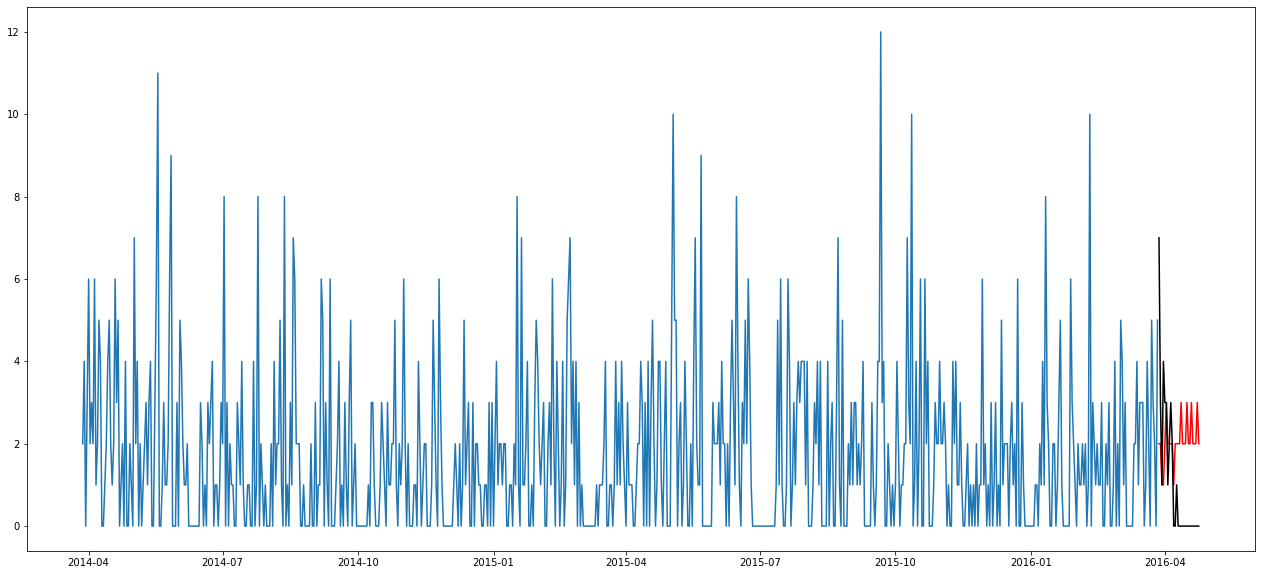

In [17]:
plt.figure(figsize=(22, 10))

# plt.plot(residuals, label='Train')
# plt.hist(residuals[0])

plt.plot(xTrain['date'], yTrain, label='Train')
plt.plot(xTest['date'], yPred.round(), label='Regression Pred', color='r')
plt.plot(xTest['date'], dfValid.iloc[i,], label='Validation', color='k')

# plt.plot(xTrain['date'], resid, label='Train')

# plt.hist(resid)

plt.show()


Declare the evaluator and score

In [112]:
# input dimensions must be 30490 x 28
e = evaluator.WRMSSEEvaluator(dfTrainFull, dfValid, calendarDF, pricesDF)

92%|█████████▏| 11/12 [00:00<00:00, 30.91it/s]

In [113]:
# score results - as of 3/24 current leaders are at something like .55
e.score(ydfPred)


# # totally naive "last 28 days"
# e.score(dfTrain.iloc[:,-28:].rename(columns=dict(zip(dfTrain.iloc[:,-28:].columns.tolist(), dfValid.columns.tolist()))))

0.7504339162968612

-------------------------------------------------------------------------------------

Everything below this point generates a submission file.

In [22]:
dayStart = 1155


dfTrainFull = df.iloc[:, :]
dfValid = df.iloc[:, :].copy()
dfTrain = df.iloc[:, 6+(dayStart-1):]
dfLabels = df.iloc[:, :6]

# prepare X data 

# make dummies
xDF = pd.get_dummies(calendarDF.fillna(0), columns=['event_name_1', 'event_name_2', 'wday','month'])
# xDF = pd.get_dummies(calendarDF.fillna(0), columns=['event_name_1', 'event_name_2', 'wday'])

snapList = ['snap_CA', 'snap_TX', 'snap_WI']

# merge duplicate events
xDF['event_name_1_Easter'] = xDF['event_name_1_Easter'] + xDF['event_name_2_Easter']
xDF['event_name_1_Cinco De Mayo'] = xDF['event_name_1_Cinco De Mayo'] + xDF['event_name_2_Cinco De Mayo']
xDF['event_name_1_OrthodoxEaster'] = xDF['event_name_1_OrthodoxEaster'] + xDF['event_name_2_OrthodoxEaster']
xDF["event_name_1_Father's day"] = xDF["event_name_1_Father's day"] + xDF["event_name_2_Father's day"]

# remove duplicates
columnList = ['event_name_1_Chanukah End', 'event_name_1_Christmas',
       'event_name_1_Cinco De Mayo', 'event_name_1_ColumbusDay',
       'event_name_1_Easter', 'event_name_1_Eid al-Fitr',
       'event_name_1_EidAlAdha', "event_name_1_Father's day",
       'event_name_1_Halloween', 'event_name_1_IndependenceDay',
       'event_name_1_LaborDay', 'event_name_1_LentStart',
       'event_name_1_LentWeek2', 'event_name_1_MartinLutherKingDay',
       'event_name_1_MemorialDay', "event_name_1_Mother's day",
       'event_name_1_NBAFinalsEnd', 'event_name_1_NBAFinalsStart',
       'event_name_1_NewYear', 'event_name_1_OrthodoxChristmas',
       'event_name_1_OrthodoxEaster', 'event_name_1_Pesach End',
       'event_name_1_PresidentsDay', 'event_name_1_Purim End',
       'event_name_1_Ramadan starts', 'event_name_1_StPatricksDay',
       'event_name_1_SuperBowl', 'event_name_1_Thanksgiving',
       'event_name_1_ValentinesDay', 'event_name_1_VeteransDay', 
       'wday_1', 'wday_2', 'wday_3', 'wday_4', 'wday_5', 'wday_6', 'wday_7',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
xDF = xDF[columnList]

dayNum = pd.DataFrame(np.arange(1,len(xDF)+2),columns=['dayNum'])

xDF['dayNum'] = dayNum

xDF = pd.concat([xDF, calendarDF[snapList], pd.to_datetime(calendarDF.date)], axis=1)

noDate = xDF.columns.tolist()
noDate.remove('date')


In [89]:
# prep prediction dataframe
ydfPred = pd.DataFrame(columns=dfSub.columns[1:])

# split train validate
xTrain = xDF.iloc[dayStart-1:dayStart-1+dfTrain.shape[1],:]
xTest = xDF.iloc[dayStart-1+dfTrain.shape[1]:dayStart-1+dfTrain.shape[1]+28,:]

# set ARIMA predictions to zero to add nothing at the end if commented out
ARIMApred = np.zeros((28,))

# loop for each product
for i in range(0,int(len(dfTrain))):

    yTrain = dfTrain.iloc[i,:]

    # train
    regressor = LinearRegression()  
    regressor.fit(xTrain[noDate], yTrain)

    # # # ---------------------------------------comment for ARIMA---------------------

    # # # residuals from linear regression
    # residLinear = yTrain - regressor.predict(xTrain[noDate])

    # # # arima model from residuals
    # model = ARIMA(pd.Series(residLinear.to_list(), index=xTrain['date']), order=(5,1,2))
    # ARIMA_fit = model.fit()

    # # # make ARIMA prediction
    # ARIMApred = ARIMA_fit.predict(start=xTest.iloc[0]['date'], end=xTest.iloc[-1]['date'], dynamic=True)

    # # # -----------------------------------------------------------------------------

    # print(ARIMA_fit.summary())
    # residuals = pd.DataFrame(ARIMA_fit.resid)

    yPred = regressor.predict(xTest[noDate]) + ARIMApred


    # add to prediction dataframe
    ydfPred = ydfPred.append(pd.Series(yPred.round(), index=dfSub.columns[1:]), ignore_index=True)

    # progress output
    if i % 1000 == 0:
        print(i)
        
ydfPred[ydfPred < 0] = 0

print("Done.")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
Done.


In [106]:
submissionDF_path = os.path.join(os.getcwd(), 'data', 'sample_submission.csv')
submitDF = pd.read_csv(submissionDF_path)


output = ydfPred.append(pd.DataFrame(np.zeros(shape=ydfPred.shape), columns=ydfPred.columns), ignore_index=True)
output = pd.concat([submitDF['id'], output], axis=1)

submissionSubmit_path = os.path.join(os.getcwd(), 'submit.csv')
output.to_csv(submissionSubmit_path, index=False)

